<a href="https://colab.research.google.com/github/abhiraman/Capstone_Project/blob/main/Text_Detection_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Detectron2 

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1.2
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

# Import Detectron2 dependencies

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Load Train Images from Drive

In [5]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [6]:
!ls
%cd My Drive/Capstone_project_data/Synthetic Train Set - Detection & Recognition

MyDrive
/gdrive/My Drive/Capstone_project_data/Synthetic Train Set - Detection & Recognition


In [7]:
!ls

Annotation  Images  input.jpg  output  readme.txt  train_crop_annot.txt


# Unzip the Custom Data

In [8]:
#!unzip 'Synthetic Train Set - Detection & Recognition.zip'

# Store Data in Detectron2 format 

In [9]:
from detectron2.structures import BoxMode

def get_text_dicts(img_dir,annot_directory,view_data = False):
    print("annot_directory",annot_directory)
    
     ## read a text File ## 
    if view_data:
      all_text_files = os.listdir(annot_directory)[:4]
    else:
      all_text_files = os.listdir(annot_directory)[0:500]
    #print("all_text_files",all_text_files)

    dataset_dicts = []
    for e_file in all_text_files:
        record = {}
        
        filename = os.path.join(img_dir, e_file.replace('.txt','.jpg'))
        #print("filename",filename)
        try:
          height, width = cv2.imread(filename).shape[:2]
        except:
          continue
        
        record["file_name"] = filename
        record["image_id"] = e_file.strip('.txt')
        record["height"] = height
        record["width"] = width
      
        objs = []
        annot_file_name = os.path.join(annot_directory,e_file)
        with open(annot_file_name,'r') as fh:
            all_lines = fh.readlines()
        
        fh.close()
        for e_line in all_lines:
         # print(e_line)
          split_list = e_line.split(' ')
          px = [float(e_str) for e_str in split_list[0:4]]
          py = [float(e_str) for e_str in split_list[4:8]]
          poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
          poly = [p for x in poly for p in x]
          obj = {
              "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
              "bbox_mode": BoxMode.XYXY_ABS,
              "segmentation": [poly],
              "category_id": 0,
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

Register the Datasets

In [11]:
for d in range(1,15):
  d = str(d)
  try:
    DatasetCatalog.register("./Images/" +d, lambda d=d: get_text_dicts("./Images/"+d,"./Annotation/"+d))
    MetadataCatalog.get("./Images/" +d).set(thing_classes=["Text"])
  except:
    pass


Add all training dataset directories in one

In [12]:
import re
all_datasets = list(DatasetCatalog.data.keys())
pattern = re.compile("./Images/")

custom_dataset = (e_dataset for e_dataset in all_datasets if re.match(pattern,e_dataset)!=None)
custom_dataset = tuple(custom_dataset)
print("custom_dataset",custom_dataset)

custom_dataset ('./Images/1', './Images/2', './Images/3', './Images/4', './Images/5', './Images/6', './Images/7', './Images/8', './Images/9', './Images/10', './Images/11', './Images/12', './Images/13', './Images/14')


# View Sample Data 

annot_directory ./Annotation/16


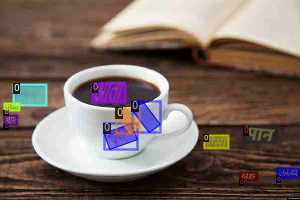

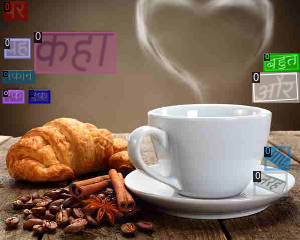

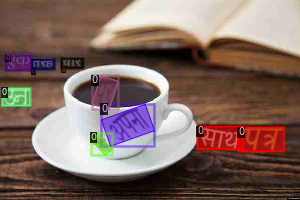

In [13]:
dd = str(np.random.randint(1,25))
TextIdentifier_MData = MetadataCatalog.get("./Image/"+dd)
dataset_dicts = get_text_dicts("./Images/"+dd,"./Annotation/"+dd,view_data=True)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=TextIdentifier_MData, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# Pre-Train Model With CoCo Set & Train with Custom Set

In [14]:
cfg = get_cfg()

In [ ]:
from detectron2.engine import DefaultTrainer


cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = custom_dataset
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good Learning Rate
cfg.SOLVER.MAX_ITER = 1000   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   #(default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class ("Text"). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)

trainer.resume_or_load(resume=False)
trainer.train()

In [19]:
fh = open("Obj_config.yml",'w')
fh.write(cfg.dump())
fh.close()

## Inference & evaluation using the trained model


In [17]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
print(cfg.MODEL.WEIGHTS)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

./output/model_final.pth


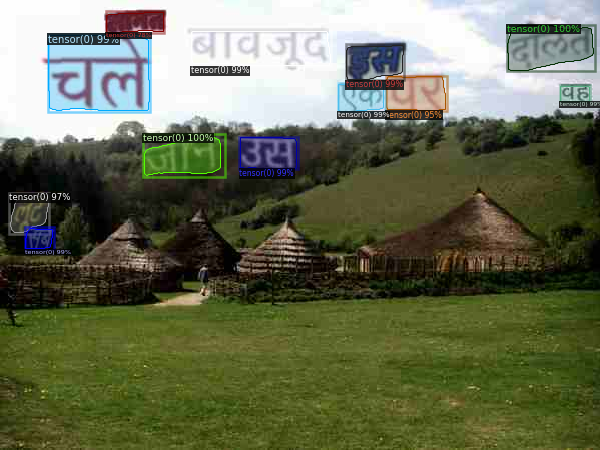

predBox_dims ---->   [[142.62286376953125, 133.56393432617188, 224.84963989257812, 176.86317443847656], [506.84747314453125, 24.67040252685547, 594.6021728515625, 71.277099609375], [191.00537109375, 30.463247299194336, 330.8952331542969, 66.33794403076172], [239.4909210205078, 136.8878936767578, 297.76904296875, 168.97586059570312], [559.93017578125, 85.42914581298828, 590.0995483398438, 101.80919647216797], [25.14815902709961, 227.4374237060547, 53.71002960205078, 249.6708984375], [337.7480163574219, 82.94336700439453, 384.5304870605469, 111.72684478759766], [346.1854553222656, 44.48492431640625, 403.85223388671875, 80.2722396850586], [47.8318977355957, 34.12767028808594, 149.71664428710938, 111.6246337890625], [9.200925827026367, 193.4334259033203, 49.32928466796875, 233.9394073486328], [386.1514892578125, 75.88895416259766, 446.83782958984375, 110.5413589477539], [105.53456115722656, 11.368953704833984, 164.4451141357422, 33.02342987060547]]


In [56]:
#def infer_obj_detect(img_dir,cfg):
from detectron2.utils.visualizer import ColorMode

def _infer_obj_detection(image_dir,image,predictor):   
  full_path = os.path.join(image_dir,image)
  inputs = cv2.imread(full_path)
  outputs = predictor(inputs)
  v = Visualizer(inputs[:, :, ::-1],metadata=None,scale=1,instance_mode=ColorMode.IMAGE_BW )  # remove the colors of unsegmented pixels. This option is only available for segmentation models
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
  return outputs["instances"]._fields["pred_boxes"].tensor.tolist()

predBox_dims = _infer_obj_detection(r"./Images/25","28.jpg",predictor)
print("predBox_dims ---->  ",predBox_dims)